### Import packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import math
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta

### 1. Read CSV data of prices from GitHub

In [8]:
# Github url to raw data sources
git_url = "https://raw.githubusercontent.com/kamu2023/3619/develop/"

In [72]:
# Fetching prices
brent_oil = pd.read_csv(git_url + 'Brent_monthly.csv')
wti_oil = pd.read_csv(git_url + 'wti_monthly.csv')
nigeria_oil = pd.read_csv(git_url + 'nigeria_monthly_crude.csv')
kerosene_oil = pd.read_csv(git_url + 'Jet_Fuel_Price.csv')

#### a) Quick Peak into the data

In [73]:
brent_oil.head()

,DATE,MCOILBRENTEU
0,01/05/1987,18.58
1,01/06/1987,18.86
2,01/07/1987,19.86
3,01/08/1987,18.98
4,01/09/1987,18.31


In [74]:
wti_oil.head()

,DATE,POILWTIUSDM
0,01/01/1990,22.604348
1,01/02/1990,22.202500
2,01/03/1990,20.440455
3,01/04/1990,18.526667
4,01/05/1990,18.443043


In [75]:
nigeria_oil.head()

,Year,Month,Crude Oil Price
0,2006,1,63.85
1,2006,2,61.33
2,2006,3,65.00
3,2006,4,72.09
4,2006,5,71.18


In [103]:
kerosene_oil.head()

,Date,Jet Fuel Spot Price
0,"Apr 02, 1990",0.550
1,"Apr 03, 1990",0.555
2,"Apr 04, 1990",0.560
3,"Apr 05, 1990",0.540
4,"Apr 06, 1990",0.536


### 2) Data Transformation

In [76]:
## Changing Column Names
def change_column_name(df, old_col, new_col):
    df.rename(columns={old_col:new_col}, inplace=True)
    return df

In [77]:
## Format dates to read in the same order
def format_dates(df, col):
    df[col] = pd.to_datetime(df[col])
    df[col] = pd.to_datetime(df[col].dt.strftime('%Y-%d-%m'))
    return df

In [78]:
brent_oil = change_column_name(brent_oil, 'MCOILBRENTEU', 'Brent')
wti_oil = change_column_name(wti_oil, 'POILWTIUSDM', 'WTI')
nigeria_oil = change_column_name(nigeria_oil, 'Crude Oil Price', 'Nigeria')

In [79]:
brent_oil = format_dates(brent_oil, 'DATE')
wti_oil = format_dates(wti_oil, 'DATE')

In [80]:
## Transforming the data for Nigeria
nigeria_oil['DATE'] = pd.to_datetime(nigeria_oil[['Year', 'Month']].assign(DAY=1))
for col in ['Year', 'Month']:
    nigeria_oil.drop(col, inplace=True, axis=1)

In [81]:
## Change order of columns 
nigeria_oil = nigeria_oil[['DATE', 'Nigeria']]

In [82]:
## Merging the datapoints (datasets)
data = (nigeria_oil.merge(brent_oil).merge(wti_oil))

In [83]:
data.head()

,DATE,Nigeria,Brent,WTI
0,2006-01-01,63.85,62.99,65.232727
1,2006-02-01,61.33,60.21,61.544000
2,2006-03-01,65.00,62.06,62.899565
3,2006-04-01,72.09,70.26,69.673500
4,2006-05-01,71.18,69.78,70.959130


In [86]:
data.tail()

,DATE,Nigeria,Brent,WTI
204,2023-01-01,84.78,82.50,78.251364
205,2023-02-01,86.04,82.59,77.027500
206,2023-03-01,81.10,78.43,73.348261
207,2023-05-01,76.91,75.47,71.673478
208,2023-06-01,76.97,74.84,70.306818


In [92]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

### 3. Data Analysis

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2006-01-01 to 2023-06-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Nigeria  209 non-null    float64
 1   Brent    209 non-null    float64
 2   WTI      209 non-null    float64
dtypes: float64(3)
memory usage: 6.5 KB


In [94]:
data.describe()

,Nigeria,Brent,WTI
count,209.000000,209.000000,209.000000
mean,78.420526,76.802249,72.181214
std,26.077256,25.134670,22.434522
min,14.280000,18.380000,16.975000
25%,59.490000,57.810000,54.666000
50%,74.720000,73.160000,70.959130
75%,103.820000,101.610000,91.608000
max,138.740000,132.720000,133.958261


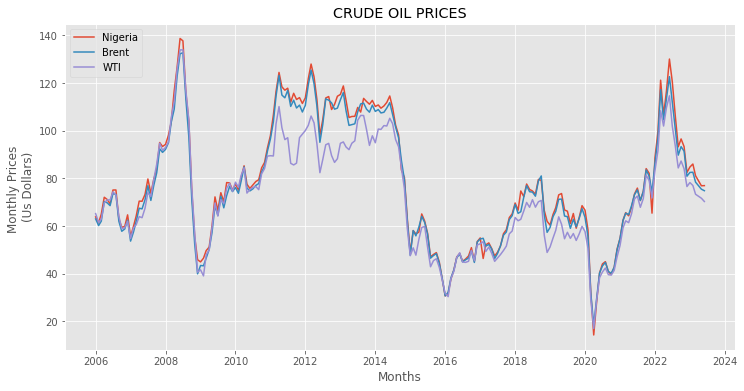

In [96]:
tickers = [ticker for ticker in data.columns if data[ticker].dtypes !='O']

style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.plot(data)
plt.xlabel('Months')
plt.ylabel('Monthly Prices \n(Us Dollars)')
plt.title('CRUDE OIL PRICES')
plt.legend(tickers)
plt.show()

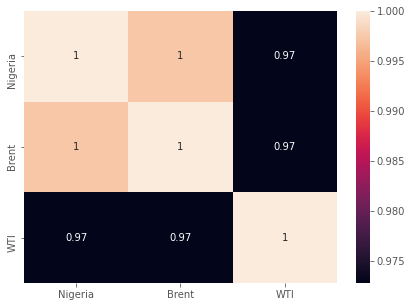

In [97]:
### Correlation Matrix
matrix = data.corr()
fig = plt.figure(figsize=(7,5))
sns.heatmap(matrix, annot=True)
plt.show()

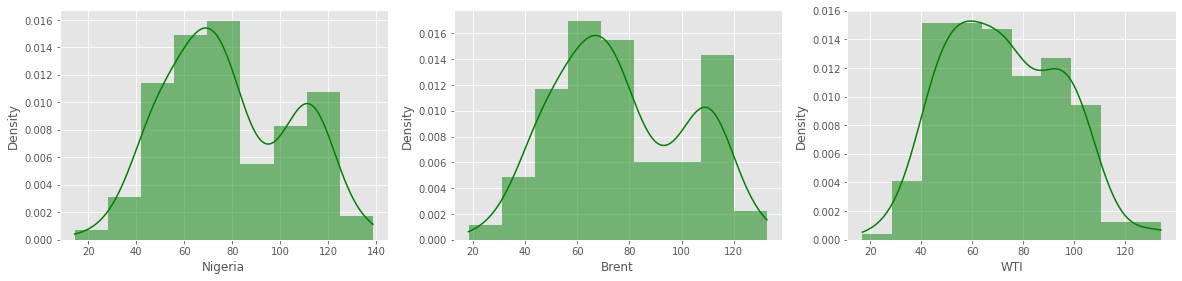

In [100]:
## Time series plots
plt.figure(figsize=(20,60))
plotnumber = 1
for feature in tickers:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(data[feature], color='green', kde=True, stat='density', linewidth=0)
    plotnumber += 1
plt.show()

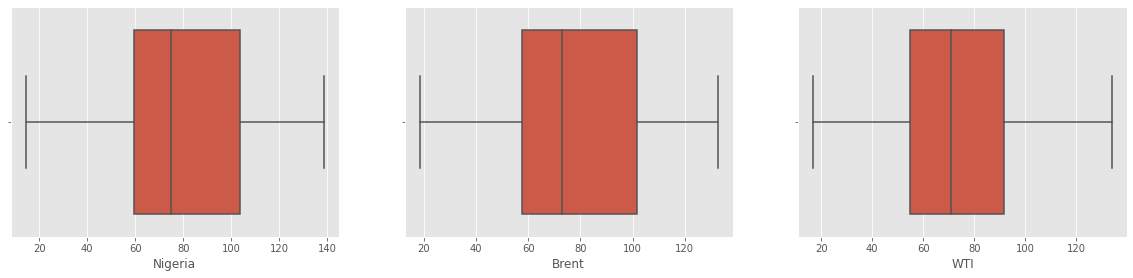

In [102]:
### Box and Whisker Plot
plt.figure(figsize=(20,60))
plotnumber = 1
for feature in tickers:
    ax = plt.subplot(12, 3, plotnumber)
    sns.boxplot(x=data[feature])
    plt.xlabel(feature)
    plotnumber += 1
plt.show()

In [104]:
### Regression Analysis
def scatter_plot(ticker):
    plt.figure(figsize=(20,60))
    plotnumber = 1
    for item in tickers:
        ax = plt.subplot(12, 3, plotnumber)
        plt.scatter(data[item], data[ticker])
        plt.xlabel(item.capitalize())
        plt.ylabel(ticker.capitalize())
        plotnumber += 1
    plt.show()

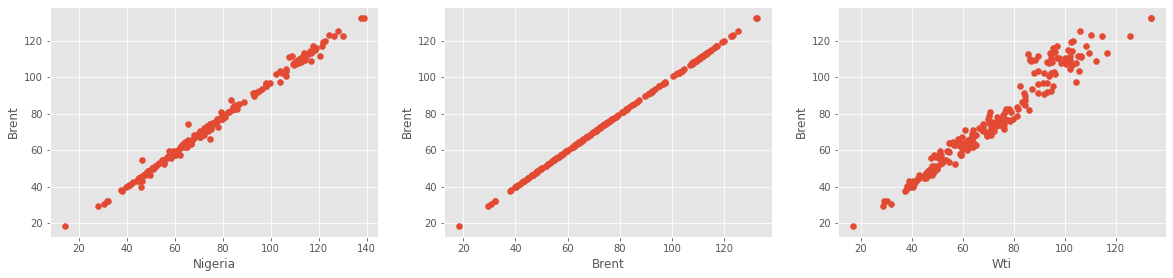

In [105]:
scatter_plot('Brent')

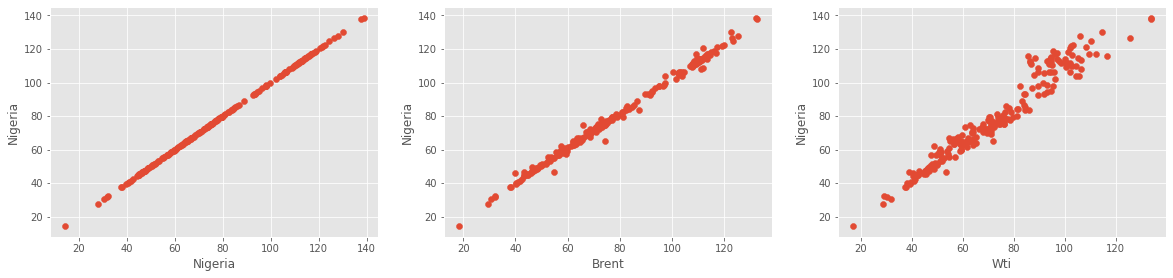

In [106]:
scatter_plot('Nigeria')

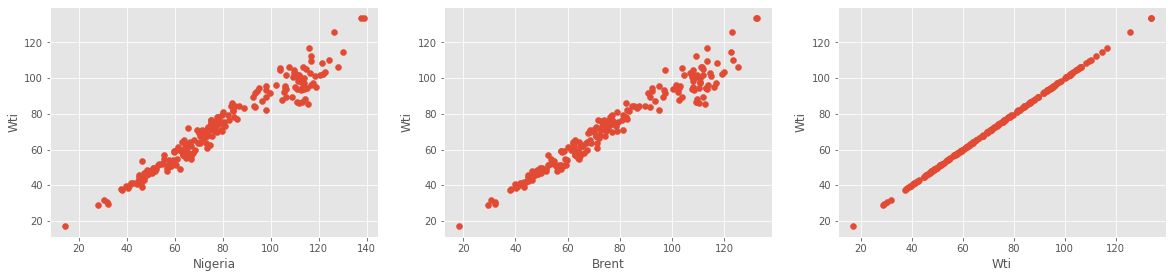

In [107]:
scatter_plot('WTI')

### Crude Oil Products Prices Analysis

In [108]:
# Fetching oil products prices
kerosene = pd.read_csv(git_url + 'keroseneUS.csv')
diesel = pd.read_csv(git_url + 'dieselUS.csv')
gasoline = pd.read_csv(git_url + 'gasolineUS.csv')

In [109]:
kerosene.head()

,DATE,MJFUELUSGULF
0,01/04/1990,0.540
1,01/05/1990,0.515
2,01/06/1990,0.494
3,01/07/1990,0.535
4,01/08/1990,0.791


In [110]:
diesel.head()

,DATE,APU000074717
0,01/01/1998,1.250
1,01/02/1998,1.220
2,01/03/1998,1.192
3,01/04/1998,1.184
4,01/05/1998,1.190


In [111]:
gasoline.head()

,DATE,APU000074714
0,01/01/1976,0.605
1,01/02/1976,0.600
2,01/03/1976,0.594
3,01/04/1976,0.592
4,01/05/1976,0.600


In [112]:
kerosene = change_column_name(kerosene, 'MJFUELUSGULF', 'Kerosene_US')
diesel = change_column_name(diesel, 'APU000074717', 'Diesel_US')
gasoline = change_column_name(gasoline, 'APU000074714', 'Gasoline_US')

In [113]:
kerosene = format_dates(kerosene, 'DATE')
diesel = format_dates(diesel, 'DATE')
gasoline = format_dates(gasoline, 'DATE')

In [126]:
kerosene.head()

,DATE,Kerosene_US
0,1990-04-01,0.540
1,1990-05-01,0.515
2,1990-06-01,0.494
3,1990-07-01,0.535
4,1990-08-01,0.791


In [116]:
## Merging the datapoints (datasets)
data2 = (kerosene.merge(diesel).merge(gasoline))
data2

,DATE,Kerosene_US,Diesel_US,Gasoline_US
0,1998-01-01,0.476,1.250,1.131
1,1998-02-01,0.449,1.220,1.082
2,1998-03-01,0.413,1.192,1.041
3,1998-04-01,0.426,1.184,1.052
4,1998-05-01,0.416,1.190,1.092
...,...,...,...,...
302,2023-03-01,2.679,4.359,3.551
303,2023-04-01,2.374,4.215,3.735
304,2023-05-01,2.173,4.074,3.685
305,2023-06-01,2.250,3.941,3.712


In [122]:
data2['DATE'] = pd.to_datetime(data2['DATE'])
data2.set_index('DATE', inplace=True)

In [123]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 307 entries, 1998-01-01 to 2023-07-01
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kerosene_US  307 non-null    float64
 1   Diesel_US    307 non-null    float64
 2   Gasoline_US  307 non-null    float64
dtypes: float64(3)
memory usage: 9.6 KB


In [124]:
data2.describe()

,Kerosene_US,Diesel_US,Gasoline_US
count,307.000000,307.000000,307.000000
mean,1.775068,2.780544,2.500801
std,0.899167,1.028640,0.865310
min,0.304000,1.094000,0.955000
25%,0.982500,1.868500,1.777000
50%,1.754000,2.818000,2.496000
75%,2.347500,3.436500,3.170000
max,4.120000,5.758000,5.058000


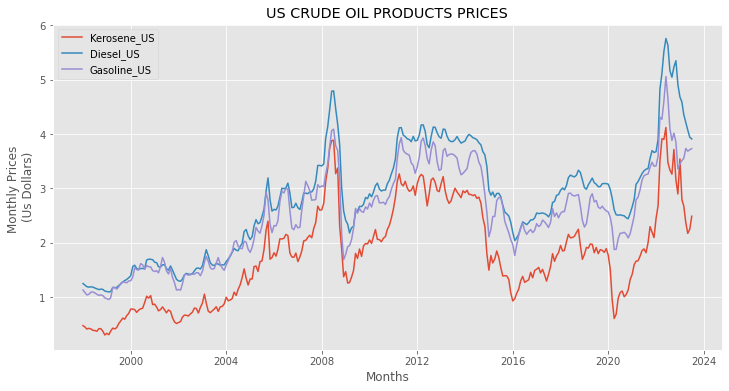

In [130]:
tickers = [ticker for ticker in data2.columns if data2[ticker].dtypes !='O']

style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.plot(data2)
plt.xlabel('Months')
plt.ylabel('Monthly Prices \n(Us Dollars)')
plt.title('US CRUDE OIL PRODUCTS PRICES')
plt.legend(tickers)
plt.show()

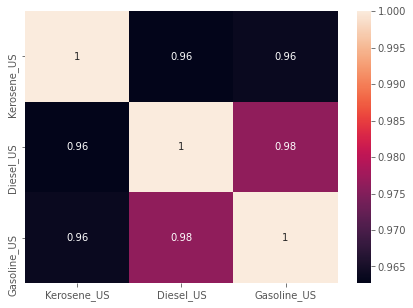

In [131]:
### Correlation Matrix
matrix = data2.corr()
fig = plt.figure(figsize=(7,5))
sns.heatmap(matrix, annot=True)
plt.show()

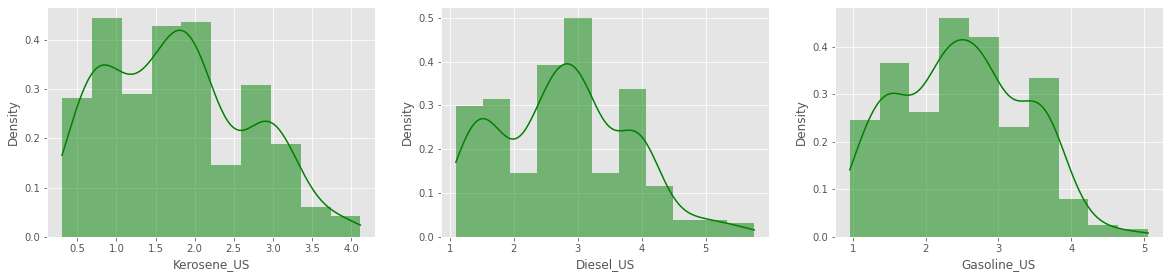

In [134]:
## Time series plots
plt.figure(figsize=(20,60))
plotnumber = 1
for feature in tickers:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(data2[feature], color='green', kde=True, stat='density', linewidth=0)
    plotnumber += 1
plt.show()